In [1]:
cd ..

/Users/amiyaguchi/wikipedia-retention


In [2]:
from pyspark.sql import SparkSession, Row, functions as F, types as T
import pandas as pd
import numpy as np

spark = SparkSession.builder.getOrCreate()

# read the network for 2007Q1
snapshot = spark.read.csv(
    "data/processed/2007-1-user-network-v3.csv",
    sep='\t',
    schema="src INT, dst INT, weight INT"
)

# read the role distribution information
roleG = pd.read_csv("data/processed/roles/2007-1-nmf-G.csv")

x = roleG.apply(lambda x: Row(
    user_id=int(x[0]), 
    vec=x[1:].astype(float).tolist()
), axis=1).values

rolx_df = spark.createDataFrame(list(x))

In [34]:
# generate features

enwiki = spark.read.parquet("data/processed/enwiki-meta-compact")

user_text = (
    enwiki
    .where("year=2007 and quarter=1")
    .groupby("user_id")
    .agg(
        F.expr("count(distinct article_id) as n_articles"),
        F.expr("count(*) as n_edits"),
        F.expr("sum(log(textdata)) as edit_count")
    )
)

In [619]:
from sklearn.decomposition import NMF

rolx_vec = pd.read_csv(
    "data/processed/roles/2007-1-v", 
    header=None, 
    sep=" "
)
rolx_mapping = pd.read_csv(
    "data/processed/roles/2007-1-mappings", 
    header=None, 
    skiprows=1, 
    sep=" "
)
df = pd.concat([rolx_mapping, rolx_vec], axis=1).iloc[:, 1:]

nmf = NMF(n_components=8,
          solver="mu", 
          #beta_loss="kullback-leibler",
          tol=1e-6,
          max_iter=1000)

X = df.values[:, 1:]
W = nmf.fit_transform(X)
roleG = pd.concat([df.iloc[:, 0], pd.DataFrame(W)], axis=1)

In [620]:
def to_row(r):
    return Row(user_id=int(r[0]), vec=r[1:].astype(float).tolist())

rolx_df = spark.createDataFrame(list(map(to_row, roleG.values)))

In [621]:
edgelist = (
    snapshot
    .union(snapshot.selectExpr("dst as src", "src as dst", "weight"))
    .distinct()
)

@F.udf(T.ArrayType(T.FloatType()))
def average_vec(vecs):
    avg = np.array(vecs).sum(axis=0)/len(vecs)
    return avg.astype(float).tolist()

neighbors = (
    edgelist
    .join(rolx_df.selectExpr("user_id as dst", "vec"), on="dst")
    .groupby("src")
    .agg(F.collect_list("vec").alias("vec_list"))
    .withColumn("neighborhood_roles", average_vec("vec_list"))
    .selectExpr("src as user_id", "neighborhood_roles")
)

In [622]:
df = (
    user_text
    .join(rolx_df, on="user_id", how="inner")
    .join(neighbors, on="user_id", how="inner")
    .select(
        "user_id",
        F.array("n_articles", "n_edits", "edit_count").alias("features"),
        F.expr("vec as roles"),
        "neighborhood_roles"
    )
).toPandas()

In [623]:
@F.udf(T.IntegerType())
def label(vec):
    return vec.index(max(vec))

admins = spark.read.csv("data/processed/admin_mapping.csv", schema="user_id INT, username STRING")

discrete_df = (
    user_text
    .join(rolx_df, on="user_id", how="inner")
    .join(admins, on="user_id", how="left")
    .withColumn("is_admin", F.expr("username is not null").cast('int'))
    .withColumn("label", label("vec"))
    .groupBy("label").agg(
        F.count("user_id").alias("n_users"),
        F.sum("is_admin").alias("n_admins"),
        F.avg("n_articles"),
        F.stddev("n_articles"),
        F.avg("n_edits"),
        F.stddev("n_edits"),        
        F.avg("edit_count"),
        F.stddev("edit_count"),
    )
    .withColumn("pct_admin", F.expr("n_admins*1.0/n_users"))
    .orderBy("label")
)
discrete_df.show(vertical=True)

#discrete = discrete_df.toPandas()

-RECORD 0--------------------------------------
 label                   | 0                   
 n_users                 | 110148              
 n_admins                | 74                  
 avg(n_articles)         | 3.9103569742528235  
 stddev_samp(n_articles) | 6.964786853844657   
 avg(n_edits)            | 9.422685840868649   
 stddev_samp(n_edits)    | 25.285809330721257  
 avg(edit_count)         | 62.097950466099455  
 stddev_samp(edit_count) | 174.46593330714765  
 pct_admin               | 0.0006718233649272  
-RECORD 1--------------------------------------
 label                   | 1                   
 n_users                 | 205589              
 n_admins                | 297                 
 avg(n_articles)         | 8.43357864477185    
 stddev_samp(n_articles) | 32.1373346418445    
 avg(n_edits)            | 19.43694458361099   
 stddev_samp(n_edits)    | 87.34159041769928   
 avg(edit_count)         | 133.23406699040683  
 stddev_samp(edit_count) | 603.705121258

Text(0.5, 1.0, 'Roles vs User Count')

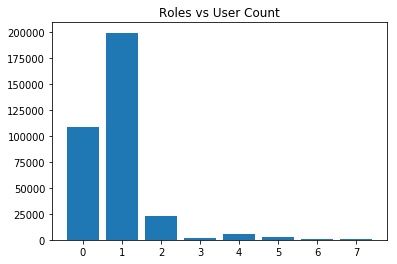

In [624]:
plt.bar(discrete.label, discrete['count'])
plt.title("Roles vs User Count")

<BarContainer object of 8 artists>

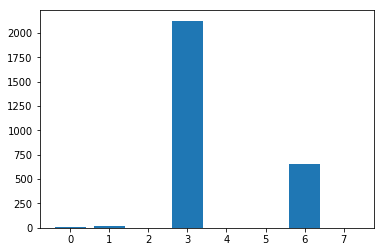

In [625]:
plt.bar(discrete.label, discrete['avg(n_edits)'])

In [626]:
from sklearn.decomposition import non_negative_factorization

print(df.shape)
df.head()

(342282, 4)


,user_id,features,roles,neighborhood_roles
0,148,"[2.0, 3.0, 22.478231383381992]","[346.03147172318637, 1777.2228620396909, 0.0, ...","[691.661376953125, 1777.6260986328125, 107.524..."
1,1591,"[507.0, 626.0, 4059.231716292192]","[555.5762169770873, 1770.1024712409373, 0.0, 2...","[1012.947509765625, 1703.3255615234375, 165.04..."
2,2122,"[3.0, 3.0, 18.201966120442165]","[1181.3254292450727, 1392.4247087763488, 1133....","[597.04638671875, 1833.0750732421875, 0.0, 710..."
3,3749,"[27.0, 65.0, 509.6047028908837]","[1523.001900116575, 1474.7672615521114, 684.90...","[761.4380493164062, 1764.702880859375, 79.4027..."
4,3997,"[1.0, 1.0, 6.543911845564792]","[4.371543167268055e-62, 1747.511124477011, 0.0...","[1068.2176513671875, 1748.511962890625, 0.0, 7..."


In [627]:
features = np.array(list(df.features))
features.shape

(342282, 3)

In [628]:
roles = np.array(list(df.roles))
roles.shape

(342282, 8)

In [629]:
neighborhood_roles = np.array(list(df.roles))
neighborhood_roles.shape

(342282, 8)

In [630]:
# W (n x r) dot H (r x f) = M (n x f)
# f x n = (f x r) dot (r x n) 

W, _, _ = non_negative_factorization(
    X = features.T,
    H = roles.T,
    n_components=roles.shape[1],
    update_H = False,
    solver='mu', 
    #beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)
W.shape

(3, 8)

In [631]:
W_def, _, _ = non_negative_factorization(
    X = features.T,
    H = np.ones((1, roles.shape[0])),
    n_components=1,
    update_H = False,
    solver='mu', 
    #beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)
W_def.shape

(3, 1)

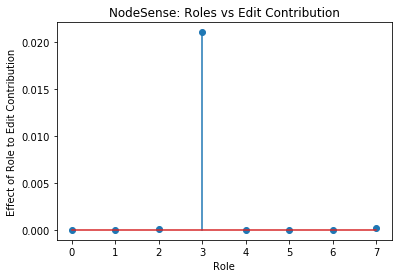

In [632]:
import matplotlib.pyplot as plt

text = (W/W_def)[2]
plt.stem(np.arange(W.shape[1]), text)
plt.title("NodeSense: Roles vs Edit Contribution")
plt.xlabel("Role")
plt.ylabel("Effect of Role to Edit Contribution")
plt.show()

In [633]:
W, _, _ = non_negative_factorization(
    X = neighborhood_roles.T,
    H = roles.T,
    n_components=roles.shape[1],
    update_H = False,
    solver='mu', 
    #beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)

In [634]:
W_def, _, _ = non_negative_factorization(
    X = neighborhood_roles.T,
    H = np.ones((1, roles.shape[0])),
    n_components=1,
    update_H = False,
    solver='mu', 
    #beta_loss="kullback-leibler", 
    init='custom',
    tol=10e-6,
    max_iter=1000
)

Text(0.5, 1.0, 'NeighborhoodSense: Role Affinities')

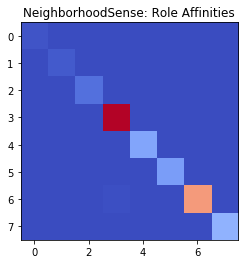

In [635]:
plt.imshow((W/W_def).T, cmap="coolwarm")
plt.title("NeighborhoodSense: Role Affinities")

## community roles

In [636]:
community_df = spark.read.csv("data/processed/user_community_assignments.csv", header=True)
community_df.show(n=5)
community_df.printSchema()

community_roles = (
    rolx_df.join(
        community_df
        .where("year='2007' and quarter='1'")
        .selectExpr("cast(user_id as int) as user_id", 
                "cast(community_id as int) as community_id"), 
        on="user_id", how="left"
    )
)
community_roles.selectExpr("count(distinct community_id)").show()

community_df = (
    community_roles
    .groupby("community_id")
    .agg(
        F.count("*").alias("size"),
        F.collect_list("vec").alias("vec_list")
    )
    .orderBy(F.desc("size"))
    .select("community_id", "size", average_vec("vec_list").alias("community_roles"))
).toPandas()

+---------+-------+----+-------+------------+
|     l_id|quarter|year|user_id|community_id|
+---------+-------+----+-------+------------+
|  3575605|      3|2005|  75605|        5506|
|173500930|      1|2007|3500930|        5152|
|173501071|      1|2007|3501071|        5152|
|173502762|      1|2007|3502762|        5152|
|173503322|      1|2007|3503322|        5152|
+---------+-------+----+-------+------------+
only showing top 5 rows

root
 |-- l_id: string (nullable = true)
 |-- quarter: string (nullable = true)
 |-- year: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- community_id: string (nullable = true)

+----------------------------+
|count(DISTINCT community_id)|
+----------------------------+
|                         440|
+----------------------------+



In [637]:
community_df[:20]

,community_id,size,community_roles
0,5152.0,339508,"[2037.7833251953125, 1424.5567626953125, 531.4..."
1,NaN,2046,"[2226.158447265625, 1322.1300048828125, 633.21..."
2,7484.0,7,"[4.223671112413285e-06, 1.182031337521039e-05,..."
3,7385.0,7,"[8.08857748779701e-06, 2.2157862986205146e-05,..."
4,7490.0,5,"[1.5903826806606958e-06, 2.9368718514888315e-0..."
5,5186.0,4,"[1.9224589777877554e-06, 7.660562914679758e-06..."
6,7460.0,3,"[0.0, 4.736045771553815e-37, 0.0, 0.0, 0.0, 4...."
7,7250.0,3,"[0.0, 4.736045771553815e-37, 0.0, 0.0, 0.0, 4...."
8,7504.0,3,"[0.0, 8.493782388541149e-07, 2.461596295688650..."
9,7355.0,3,"[0.0, 8.493782388541149e-07, 2.461596295688650..."


In [638]:
community_roles = np.array(list(community_df["community_roles"]))
community_roles.shape

(441, 8)

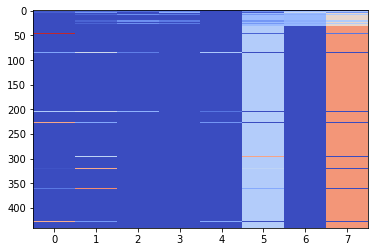

In [639]:
from sklearn.preprocessing import normalize
normed = normalize(community_roles, axis=1, norm='l1')
plt.imshow(normed, cmap='coolwarm', aspect='auto')

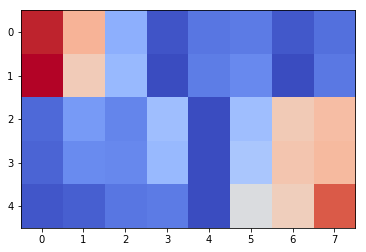

In [640]:
plt.imshow(normed[:5], cmap='coolwarm', aspect='auto')

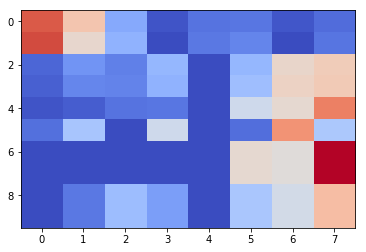

In [641]:
plt.imshow(normed[:10], cmap='coolwarm', aspect='auto')

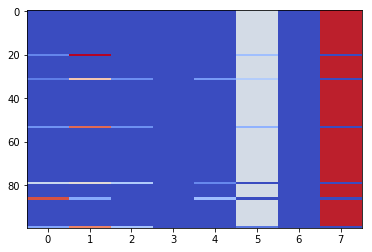

In [642]:
plt.imshow(normed[-100:], cmap='coolwarm', aspect='auto')

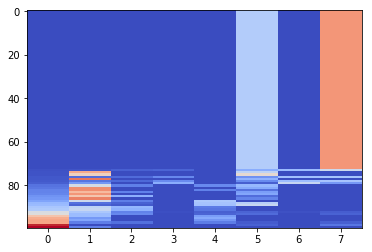

In [643]:
ind=np.argsort(normed[:,0])
b=normed[ind]
plt.imshow(b[-100:], cmap='coolwarm', aspect='auto')